In [0]:
import torch

In [5]:
!pip install fastai

In [0]:
import os
import time

# data science imports
import math
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

import warnings
warnings.filterwarnings('ignore')

# utils import
#from fuzzywuzzy import fuzz

# visualization imports
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

%reload_ext autoreload
%autoreload 2
%matplotlib inline


#from fastai.learner import *
#from fastai.column_data import *
#from fastai.imports import *
from fastai import  *

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
link = 'https://drive.google.com/open?id=1qQZmHfPgLw2QrGWnMTy4CCQm5SrgYwhu'

In [21]:
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='

1qQZmHfPgLw2QrGWnMTy4CCQm5SrgYwhu


In [22]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Data2.txt')  
dataset = pd.read_csv('Data2.txt', sep=';;', header=None, error_bad_lines=False)
# Dataset is now stored in a Pandas Dataframe

Skipping line 50647: Expected 9 fields in line 50647, saw 11. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 71068: Expected 9 fields in line 71068, saw 10. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 73612: Expected 9 fields in line 73612, saw 11. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 104136: Expected 9 fields in line 104136, saw 10. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 122095: Expected 9 fields in line 122095, saw 13. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 131883: Expected 9 fields in line 131883, saw 10. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 223766: Expected 9 fields in line 223766, saw 11. Error could possibly be 

In [9]:
dataset.shape

(878533, 9)

In [10]:
dataset.head()

,0,1,2,3,4,5,6,7,8
0,147643103,5.0,"“Truly is ""Jewel of the Upper Wets Side""”",Stayed in a king suite for 11 nights and yes i...,Papa_Panda,Gold Coast,93338,December 2012,"December 17, 2012"
1,147639004,5.0,“My home away from home!”,"On every visit to NYC, the Hotel Beacon is the...",Maureen V,"Sydney, New South Wales, Australia",93338,December 2012,"December 17, 2012"
2,147697954,4.0,“Great Stay”,This is a great property in Midtown. We two di...,vuguru,Houston,1762573,December 2012,"December 18, 2012"
3,147625723,4.0,“Modern Convenience”,The Andaz is a nice hotel in a central locatio...,Hotel-Designer,"Laguna Beach, CA",1762573,August 2012,"December 17, 2012"
4,147612823,4.0,“Its the best of the Andaz Brand in the US....”,I have stayed at each of the US Andaz properti...,JamesE339,"Saint Louis, Missouri",1762573,December 2012,"December 17, 2012"


In [0]:
dataset.columns=['review_Id', 'overall_rating','title_of_the_review','text_of_the_review','username',
                 'location_of_the_user','hotel_Id','date_stayed','date_of_the_review']

In [12]:
dataset.head()

,review_Id,overall_rating,title_of_the_review,text_of_the_review,username,location_of_the_user,hotel_Id,date_stayed,date_of_the_review
0,147643103,5.0,"“Truly is ""Jewel of the Upper Wets Side""”",Stayed in a king suite for 11 nights and yes i...,Papa_Panda,Gold Coast,93338,December 2012,"December 17, 2012"
1,147639004,5.0,“My home away from home!”,"On every visit to NYC, the Hotel Beacon is the...",Maureen V,"Sydney, New South Wales, Australia",93338,December 2012,"December 17, 2012"
2,147697954,4.0,“Great Stay”,This is a great property in Midtown. We two di...,vuguru,Houston,1762573,December 2012,"December 18, 2012"
3,147625723,4.0,“Modern Convenience”,The Andaz is a nice hotel in a central locatio...,Hotel-Designer,"Laguna Beach, CA",1762573,August 2012,"December 17, 2012"
4,147612823,4.0,“Its the best of the Andaz Brand in the US....”,I have stayed at each of the US Andaz properti...,JamesE339,"Saint Louis, Missouri",1762573,December 2012,"December 17, 2012"


In [13]:
dataset.isnull().sum()

review_Id                    0
overall_rating               7
title_of_the_review          7
text_of_the_review           7
username                 77066
location_of_the_user    117810
hotel_Id                     7
date_stayed                 13
date_of_the_review           7
dtype: int64

In [0]:
df = dataset.dropna(axis=0)

In [17]:
df.isnull().sum()

review_Id               0
overall_rating          0
title_of_the_review     0
text_of_the_review      0
username                0
location_of_the_user    0
hotel_Id                0
date_stayed             0
date_of_the_review      0
dtype: int64

In [18]:
df.shape

(760722, 9)

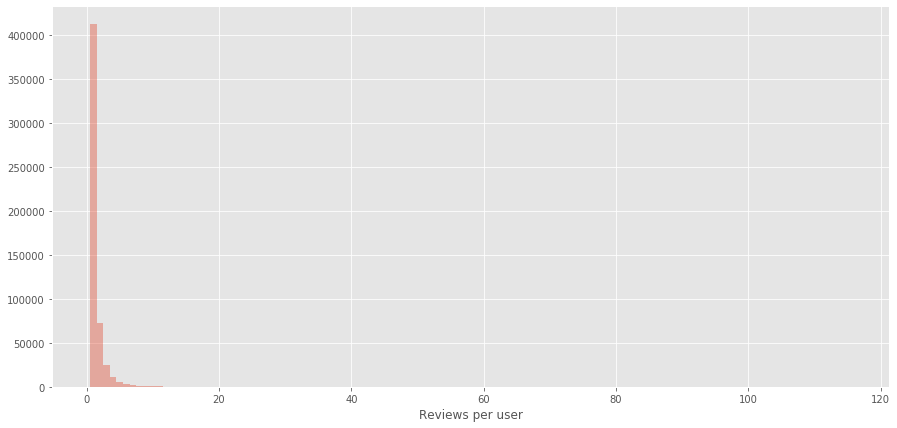

In [28]:
# most users only produce 1 review, so no user-based alignment
plt.figure(figsize=(15,7))
review_user_serie = df.groupby('username').apply(len)
review_user_serie.name = "Reviews per user"
sns.distplot(review_user_serie, bins=[i+.5 for i in range(review_user_serie.max())], kde = False)
plt.savefig('../data_2_review_user.png')

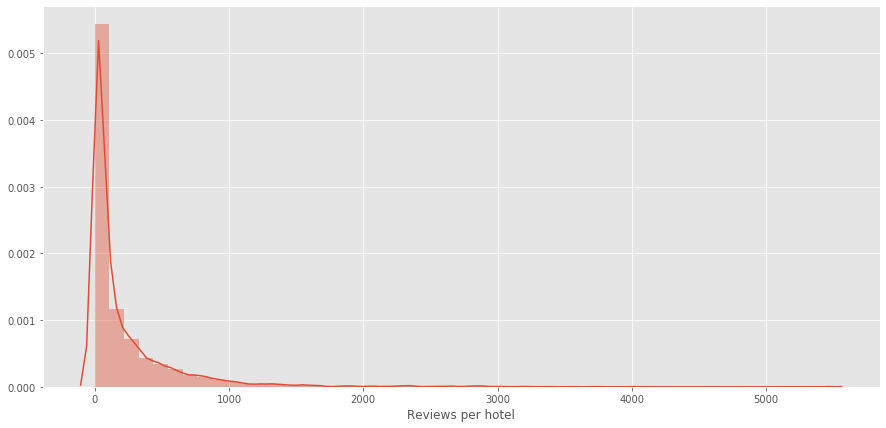

In [29]:
# most users only produce 1 review, so no user-based alignment
plt.figure(figsize=(15,7))
review_hotel_serie = df.groupby('hotel_Id').apply(len)
review_hotel_serie.name = "Reviews per hotel"
sns.distplot(review_hotel_serie)
plt.savefig('../data_2_review_hotel.png')

In [0]:
df = df[['username', 'hotel_Id', 'overall_rating']]

In [27]:
df.head()

,username,hotel_Id,overall_rating
0,Papa_Panda,93338,5.0
1,Maureen V,93338,5.0
2,vuguru,1762573,4.0
3,Hotel-Designer,1762573,4.0
4,JamesE339,1762573,4.0


In [28]:
df.shape

(878533, 3)

In [29]:
df.isnull().sum()

username          77066
hotel_Id              7
overall_rating        7
dtype: int64

In [0]:
df = df.dropna(axis=0)

In [31]:
df.isnull().sum()

username          0
hotel_Id          0
overall_rating    0
dtype: int64

In [32]:
df.shape

(801467, 3)

In [0]:
n_users=int(df.username.nunique())
n_hotels=int(df.hotel_Id.nunique())

In [35]:
print("n_users = ",n_users, "||", "n_hotels = ", n_hotels )

n_users =  536967 || n_hotels =  3928


**Let's create a cross-tab for better visualization of user ids and item ids.**

In [0]:
g = df.groupby('username')['overall_rating'].count()
topg = g.sort_values(ascending = False)[:15]

i = df.groupby('hotel_Id')['overall_rating'].count()
topi = i.sort_values(ascending = False)[:15]

In [37]:
# gettings ratings of top users and top items

join1 = df.join(topg, on='username', how = 'inner', rsuffix='_r')
join1 = join1.join(topi, on='hotel_Id', how = 'inner', rsuffix = '_r')

pd.crosstab(join1.username, join1.hotel_Id, join1.overall_rating, aggfunc=np.sum)

hotel_Id,111501,115644,122005,214197,223023,249712,611947,93437,93450,93454,93507,93520,93562,93618,99766
username,,,,,,,,,,,,,,,
David B,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN
David C,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
David H,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN
David M,NaN,NaN,NaN,NaN,4.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0
David P,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN
David S,NaN,NaN,NaN,1.0,2.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
John H,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,NaN,NaN,NaN
John M,3.0,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
John S,NaN,5.0,NaN,NaN,NaN,3.0,4.0,NaN,3.0,NaN,NaN,NaN,NaN,5.0,NaN


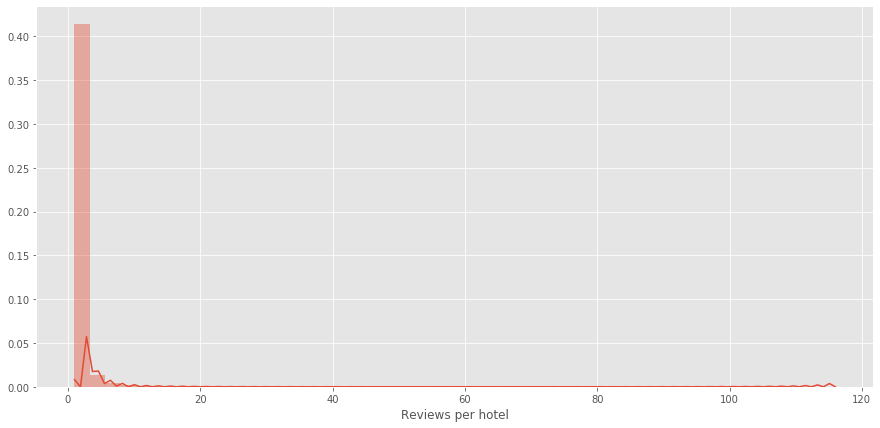

In [41]:
# most users only produce 1 review, so no user-based alignment
plt.figure(figsize=(15,7))
review_hotel_serie = df.groupby('username').apply(len)
review_hotel_serie.name = "Reviews per hotel"
sns.distplot(review_hotel_serie)
plt.savefig('../data_2_review_hotel.png')

**Surprise package**

In [42]:
!pip install scikit-surprise

In [0]:
from surprise import Reader, Dataset

In [0]:
# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(1.0, 5.0))
# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(df[['username', 'hotel_Id', 'overall_rating']], reader)

In [0]:
from surprise import SVD
from surprise.model_selection import cross_validate

**SVD**

In [46]:
# Use the famous SVD algorithm.
algo = SVD()

# Run 5-fold cross-validation and print results.
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0484  1.0527  1.0508  1.0519  1.0467  1.0501  0.0022  
MAE (testset)     0.8124  0.8158  0.8149  0.8156  0.8123  0.8142  0.0016  
Fit time          47.13   47.29   48.75   47.69   48.92   47.96   0.74    
Test time         1.62    1.19    1.26    1.70    1.75    1.50    0.24    


{'fit_time': (47.12996220588684,
  47.28805112838745,
  48.75023674964905,
  47.69353675842285,
  48.92430758476257),
 'test_mae': array([0.8123769 , 0.81581737, 0.81486918, 0.81559157, 0.81225393]),
 'test_rmse': array([1.04837633, 1.05268   , 1.05075811, 1.05194755, 1.04670023]),
 'test_time': (1.6169259548187256,
  1.1862092018127441,
  1.2550127506256104,
  1.7029197216033936,
  1.7546846866607666)}

**KNN**

In [0]:
from surprise import KNNBasic

In [0]:
# Let's try KNN algorithm also.
algo = KNNBasic()

# Run 5-fold cross-validation and print results.
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Computing the msd similarity matrix...


**NMF**

In [48]:
from surprise import NMF

# Let's try NMF algorithm also.
algo = NMF()

# Run 5-fold cross-validation and print results.
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.2392  1.2373  1.2413  1.2430  1.2402  1.2402  0.0019  
MAE (testset)     0.9546  0.9528  0.9560  0.9581  0.9544  0.9552  0.0018  
Fit time          86.06   83.95   84.20   82.63   84.00   84.17   1.10    
Test time         1.68    1.57    1.08    1.15    1.11    1.32    0.25    


{'fit_time': (86.05951285362244,
  83.94514322280884,
  84.19868612289429,
  82.62740635871887,
  83.99720048904419),
 'test_mae': array([0.95456814, 0.95278481, 0.95598625, 0.95812162, 0.95441016]),
 'test_rmse': array([1.23918003, 1.23733154, 1.24130349, 1.24298344, 1.24020899]),
 'test_time': (1.6803996562957764,
  1.566009521484375,
  1.0766241550445557,
  1.153022289276123,
  1.1131329536437988)}

**Cosine distance**

In [55]:
df[:3]

,username,hotel_Id,overall_rating
0,Papa_Panda,93338,5.0
1,Maureen V,93338,5.0
2,vuguru,1762573,4.0


In [0]:
df2 = df.copy()

In [0]:
col = ['hotel_Id', 'username']

In [54]:
for c in col:
    df2[c].replace({val: i for i, val in enumerate(df2[c].unique())}, inplace=True)

KeyboardInterrupt: ignored

In [58]:
df2[:2]

,username,hotel_Id,overall_rating
0,Papa_Panda,93338,5.0
1,Maureen V,93338,5.0


In [10]:
df3 = df2.copy()
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoder.fit_transform(df3["username"])

NameError: ignored

In [0]:
n_users=int(df3.username.nunique())
n_items=int(df3.hotel_Id.nunique())

In [3]:
print("n_users = ",n_users, "||", "n_items = ", n_items )

NameError: ignored

In [0]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(df3, test_size=0.20)

In [0]:
#Create two user-item matrices, one for training and another for testing
train_data_matrix = np.zeros((n_users, n_items))
for line in train_data.itertuples():
    train_data_matrix[line[1]-1, line[2]-1] = line[3]
    
test_data_matrix = np.zeros((n_users, n_items))
for line in test_data.itertuples():
    test_data_matrix[line[1]-1, line[2]-1] = line[3]

In [0]:
def predict(ratings, similarity, type='user'):
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1)
        #You use np.newaxis so that mean_user_rating has same format as ratings
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis])
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
    return pred

In [2]:
from sklearn.metrics.pairwise import pairwise_distances
user_similarity = pairwise_distances(train_data_matrix, metric='cosine')
item_similarity = pairwise_distances(train_data_matrix.T, metric='cosine')

NameError: ignored